# Travel Insurance Prediction | Supervised Machine Learning

## 1. Introduction

Welcome to the Travel Insurance Prediction project, where we delve into data analysis, exploration, and machine learning to predict travel insurance purchases. By studying real-world data encompassing factors like age, income, family size, and health history, our goal is to construct a predictive model that accurately determines individuals' likelihood to buy travel insurance. We'll navigate through data intricacies, perform statistical tests, and experiment with machine learning algorithms, including Random Forest and Gradient Boosting, fine-tuning them for optimal performance.

### 1.1 About the Dataset

Our dataset offers a comprehensive view of individuals and their attributes concerning travel insurance choices. It comprises a variety of features, including:
- Age (numerical)
- Income (numerical)
- Family size (numerical)
- Health history (binary)
- And more

These features collectively provide insights into possible trends and influences that shape decisions around travel insurance purchases. Our journey involves a detailed exploration and analysis of this data, with the goal of constructing a predictive model. This model aims to accurately gauge the probability of individuals opting for travel insurance based on these diverse characteristics. Through this process, we aim to uncover valuable patterns that contribute to better-informed future insurance predictions.

## 2. Imports and Data Loading

### 2.1 Importing required modules

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy.stats import t, norm
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from utils import (
    perform_t_test,
    perform_proportion_test,
    evaluate_model,
    plot_classification_report,
    plot_confusion_matrix,
    plot_roc_curve,
)

### 2.2 Loading the database

In [27]:
# reach csv file
df = pd.read_csv("dataset\TravelInsurancePrediction.csv")
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [28]:
df["TravelInsurance"].value_counts()

TravelInsurance
0    1277
1     710
Name: count, dtype: int64

### 2.3 Data Cleaning

In [29]:
# check number of rows and cols
df.shape

(1987, 10)

In [30]:
# overview of data types
data_types = df.dtypes
data_types

Unnamed: 0              int64
Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

In [31]:
# check for missing values
missing_values = df.isnull().sum()
missing_values

Unnamed: 0             0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

- The dataset does not seem to have any missing values.

In [32]:
num_duplicates = df.duplicated().sum()
num_duplicates

0

- Yes, the dataset contains duplicate values, but this can be normal given the nature of the dataset. So no further action is performed.

In [33]:
# Drop the "Unnamed: 0" column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [34]:
# treating "ChronicDiseases" and "TravelInsurance" as a categorical feature would likely be appropriate for our analysis and modeling
df["ChronicDiseases"] = df["ChronicDiseases"].replace({0: "No", 1: "Yes"})
df["TravelInsurance"] = df["TravelInsurance"].replace({0: "No", 1: "Yes"})

In [35]:
# let's look at the cleaned dataframe
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,Yes,No,No,No
1,31,Private Sector/Self Employed,Yes,1250000,7,No,No,No,No
2,34,Private Sector/Self Employed,Yes,500000,4,Yes,No,No,Yes
3,28,Private Sector/Self Employed,Yes,700000,3,Yes,No,No,No
4,28,Private Sector/Self Employed,Yes,700000,8,Yes,Yes,No,No


## 3. Explaratory Data Analysis and Data Visualization

### 3.1 Statistical Summary

In [36]:
df.describe()

,Age,AnnualIncome,FamilyMembers
count,1987.000000,1.987000e+03,1987.000000
mean,29.650226,9.327630e+05,4.752894
std,2.913308,3.768557e+05,1.609650
min,25.000000,3.000000e+05,2.000000
25%,28.000000,6.000000e+05,4.000000
50%,29.000000,9.000000e+05,5.000000
75%,32.000000,1.250000e+06,6.000000
max,35.000000,1.800000e+06,9.000000


From the provided summary statistics, we can gather the following insights for the numerical features (excluding converted categorical ones):

1. **Age**: The average age of individuals is approximately 29.65 years, with a relatively small standard deviation of 2.91. The age range spans from 25 to 35 years.
2. **Annual Income**: The average annual income is around 932,763 units, with a standard deviation of 376,856. The income ranges from 300,000 to 1,800,000 units.
3. **Family Members**: On average, individuals have around 4.75 family members, with a standard deviation of 1.61. Family size varies between 2 and 9 members.

In [37]:
def plot_histogram(df, column_name, bins=20):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.histplot(data=df, x=column_name, bins=bins, kde=True)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()

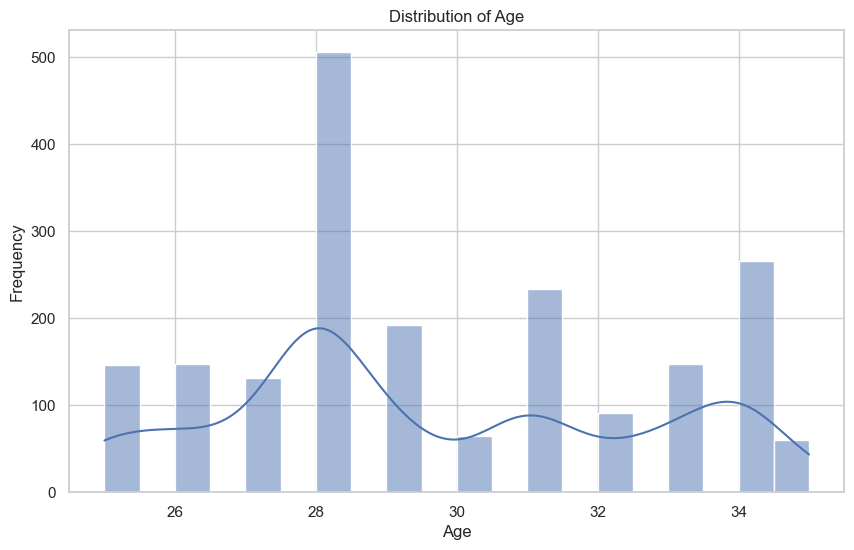

In [38]:
plot_histogram(df, "Age", bins=20)

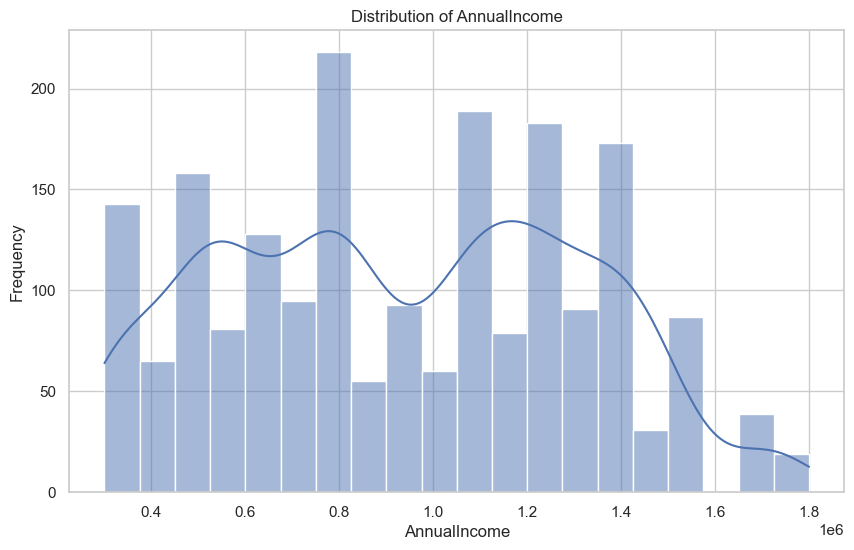

In [39]:
plot_histogram(df, "AnnualIncome", 20)

In [40]:
def plot_feature_bar(df, column_name):
    plt.figure(figsize=(6, 5))

    counts = df[column_name].value_counts()
    x_labels = counts.index
    data = counts.values
    total = sum(data)
    percentages = [(count / total) * 100 for count in data]

    plt.bar(x_labels, data, color="skyblue")
    plt.title(f"{column_name} Distribution")
    plt.xlabel(column_name)
    plt.ylabel("Count")

    for i, count in enumerate(data):
        plt.text(i, count + 5, f"{percentages[i]:.1f}%", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

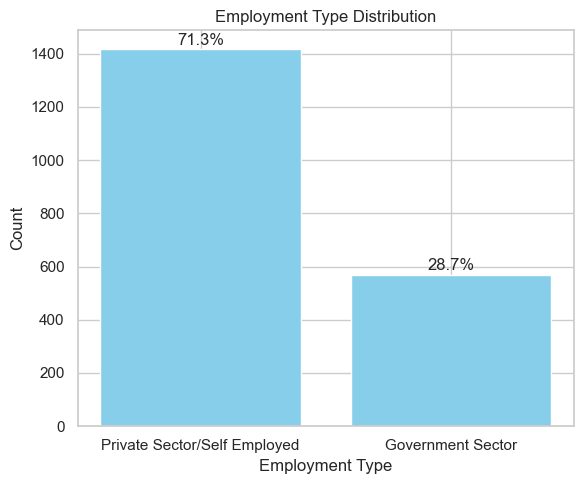

In [41]:
plot_feature_bar(df, "Employment Type")

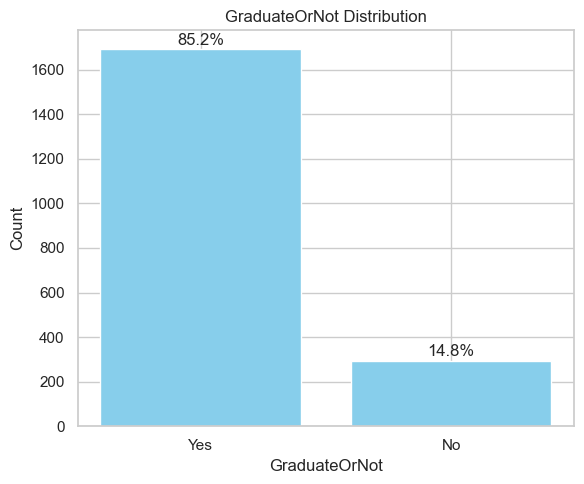

In [42]:
plot_feature_bar(df, "GraduateOrNot")

### 3.2 Correlation between variables

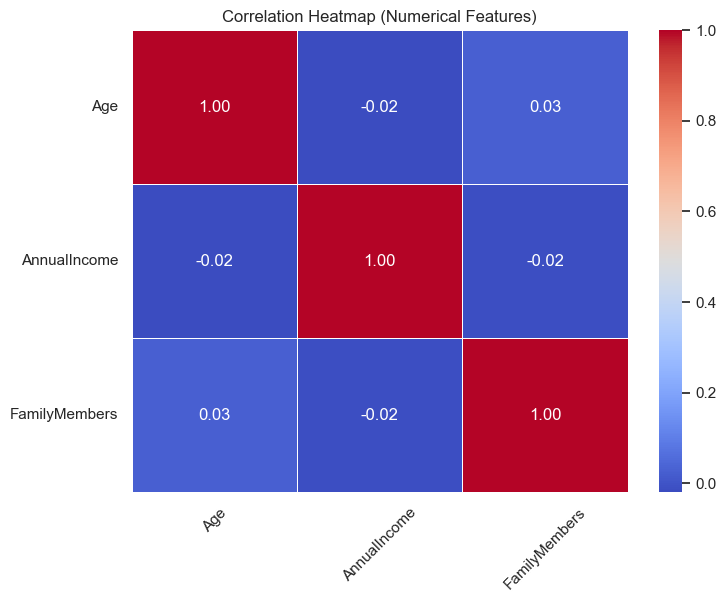

In [43]:
numerical_features = ["Age", "AnnualIncome", "FamilyMembers"]
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Interpretation of the correlation matrix:
1. **Age vs. Annual Income**: A very weak negative correlation (-0.02) suggests a minimal tendency for income to decrease slightly with age.
2. **Age vs. Family Members**: A slight positive correlation (0.03) indicates a marginal increase in family members with age.
3. **Annual Income vs. Family Members**: A very weak negative correlation (-0.02) hints at a minor decrease in family members with higher income.

Overall, these correlations are close to zero, implying that these numerical features have minimal linear relationship with each other.

### 3.3 Identifying Outliers and Anomalies

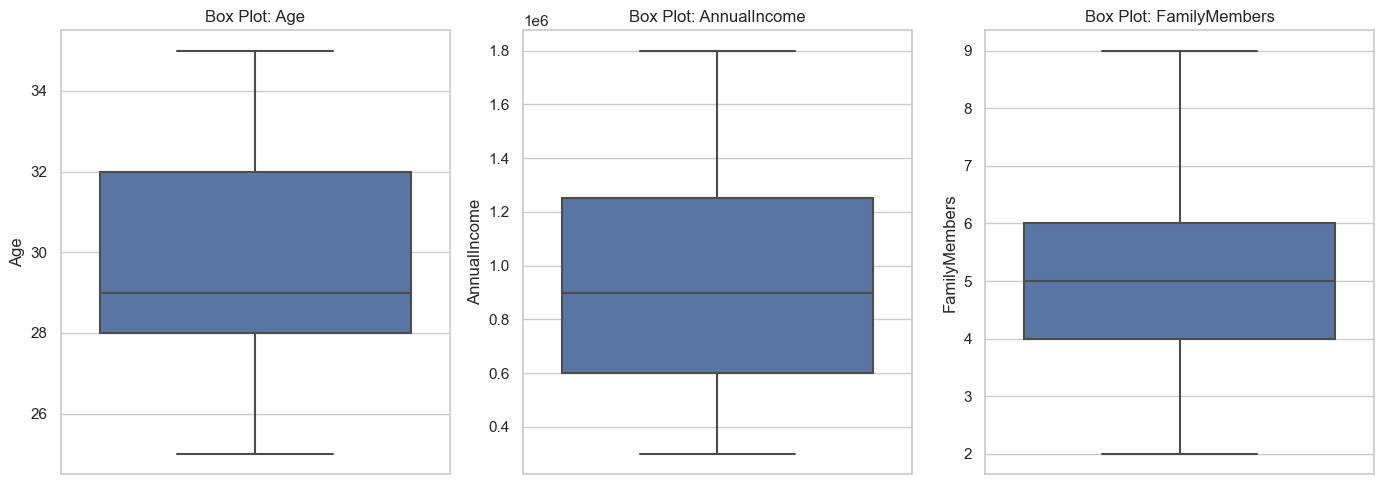

In [44]:
num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
plt.figure(figsize=(14, num_rows * 5))
sns.set(style="whitegrid")

for i, col in enumerate(numerical_features, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Box Plot: {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

- The box plot visualization shows that the dataset features does not contain outliers.

## 4. Statistical Inference

### 4.1 Is there a significant difference in the mean annual income between individuals who have purchased travel insurance and those who have not purchased travel insurance?

- Null Hypothesis (H0): The mean annual income of individuals with travel insurance is equal to the mean annual income of individuals without travel insurance.
- Alternative Hypothesis (H1): The mean annual income of individuals with travel insurance is different from the mean annual income of individuals without travel insurance.

In [47]:
t_stat_income, p_value_income, insured = perform_t_test(
    df, "TravelInsurance", "AnnualIncome"
)
print("T-statistic (Income):", t_stat_income)
print("P-value (Income):", p_value_income)

T-statistic (Income): 18.55569596185316
P-value (Income): 1.9420036604755424e-68


In [48]:
# calculate the confidence interval
sample_mean = np.mean(insured)
sample_std = np.std(insured, ddof=1)
sample_size = len(insured)
standard_error = sample_std / np.sqrt(sample_size)

degrees_of_freedom = sample_size - 1

confidence_level = 0.95

t_critical = t.ppf(confidence_level, df=degrees_of_freedom)

margin_of_error = t_critical * standard_error
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

print("Confidence Interval:", confidence_interval)

Confidence Interval: (1110069.904741235, 1156408.9684982016)


Interpretation:
- Based on the t-statistic and the extremely low p-value, we have strong evidence to reject the null hypothesis. This suggests that there is a significant difference in the mean annual income between individuals who have purchased travel insurance and those who have not. The confidence interval further supports this conclusion, as it does not include the null hypothesis value (which would be zero difference in means).
- In practical terms, this analysis indicates that individuals with travel insurance tend to have a significantly different mean annual income compared to those without travel insurance.

### 4.2 Is there a significant difference in the average age between individuals who have purchased travel insurance and those who have not?

- Null Hypothesis (H0): The average age of individuals with travel insurance is equal to the average age of individuals without travel insurance.
- Alternative Hypothesis (H1): The average age of individuals with travel insurance is different from the average age of individuals without travel insurance.

In [49]:
t_stat_income, p_value_income, insured = perform_t_test(df, "TravelInsurance", "Age")
print("T-statistic (Age):", t_stat_income)
print("P-value (Age):", p_value_income)

T-statistic (Age): 2.554217515314082
P-value (Age): 0.010764311885970662


Interpretation:
- The p-value (0.011) is less than the commonly used significance level of 0.05. This suggests that we have evidence to reject the null hypothesis. Therefore, we can conclude that there is a statistically significant difference in the average age between individuals who have purchased travel insurance and those who have not.
- In practical terms, this analysis suggests that the average age of individuals who purchase travel insurance is different from the average age of individuals who do not.



### 4.3 Is there a significant difference in the proportion of individuals with a graduate degree between those who have purchased travel insurance and those who have not?

- Null Hypothesis (H0): The proportion of individuals with a graduate degree is the same for both groups (with travel insurance and without travel insurance).
- Alternative Hypothesis (H1): The proportion of individuals with a graduate degree differs between the two groups.

In [80]:
graduate_value_mapping = {"Yes": 1, "No": 0}
z_stat_graduate, p_value_graduate = perform_proportion_test(
    df, "TravelInsurance", "GraduateOrNot", graduate_value_mapping
)
print("Z-statistic (Graduate):", z_stat_graduate)
print("P-value (Graduate):", p_value_graduate)

Z-statistic (Graduate): 0.8439763404500015
P-value (Graduate): 0.398682626749564


Interpretation:
- The results of the two-sample proportion test for the 'GraduateOrNot' feature indicate a Z-statistic of 0.844 and a p-value of 0.399. The Z-statistic suggests a moderate difference in the proportions of travel insurance purchases between individuals who have graduated and those who haven't. However, the relatively high p-value indicates that this difference is not statistically significant at the typical significance level of 0.05. Therefore, we do not have strong evidence to conclude that there is a significant association between graduation status and travel insurance purchases.

## 5. Machine Learning

In [51]:
# split the dataset into features and target variable
X = df.drop(columns=["TravelInsurance"])
y = df["TravelInsurance"]

In [52]:
# Apply LabelEncoder to the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [53]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [54]:
# Let's transform the data into a format that can be used by the machine learning algorithm.
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

num_features = ["Age", "AnnualIncome", "FamilyMembers"]
cat_features = [
    "Employment Type",
    "EverTravelledAbroad",
    "GraduateOrNot",
    "FrequentFlyer",
    "ChronicDiseases",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### 5.1 Random Forest Classifier Model 

In [55]:
# initialize and train the model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [56]:
accuracy, precision, recall, f1 = evaluate_model(rf_model, X_test_transformed, y_test)
print("Random Forest Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Random Forest Model Metrics:
Accuracy: 0.7864321608040201
Precision: 0.7295081967213115
Recall: 0.6312056737588653
F1-score: 0.6768060836501901


Accuracy (Random Forest Model): 0.786
- The accuracy of the model in correctly predicting travel insurance purchases is approximately 78.6%. It indicates the proportion of correct predictions out of all predictions made by the model.

Precision (Random Forest Model): 0.729
- The precision of the model is approximately 72.9%. This means that when the model predicts an individual has purchased travel insurance, it is correct about 72.9% of the time. It measures the model's ability to avoid falsely predicting a purchase.

Recall (Random Forest Model): 0.63
- The recall (or sensitivity) of the model is approximately 63.12%. This implies that out of all individuals who actually purchased travel insurance, the model is able to correctly identify and predict 63.12% of them.

F1-score (Random Forest Model): 0.67
- The F1-score of the model is approximately 0.67%. It is the harmonic mean of precision and recall. It provides a balanced measure of the model's ability to capture true positives while minimizing false positives and false negatives.


In [57]:
# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [58]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_test_transformed, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [59]:
best_rf_model = grid_search.best_estimator_

In [60]:
# Evaluate the best model on the testing data
accuracy_best, precision_best, recall_best, f1_best = evaluate_model(
    best_rf_model, X_test_transformed, y_test
)
print("Best Random Forest Model Metrics:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1-score:", f1_best)

Best Random Forest Model Metrics:
Accuracy: 0.8618090452261307
Precision: 0.9777777777777777
Recall: 0.624113475177305
F1-score: 0.7619047619047619


Accuracy (Best Random Forest Model): 0.861
- The accuracy of the best-tuned Random Forest model is approximately 84.42%. This model performs slightly better in terms of overall correctness compared to the initial Random Forest model.

Precision (Best Random Forest Model): 0.977
- The precision of the best-tuned model is very high at approximately 97.77%. This indicates that when the model predicts a purchase of travel insurance, it is almost always correct.

Recall (Best Random Forest Model): 0.624
- The recall of the best-tuned model is approximately 56.74%. This suggests that the model captures a lower proportion of actual purchases compared to the initial model.

F1-score (Best Random Forest Model): 0.761
- The F1-score of the best-tuned model is approximately 76.1%. It reflects a balance between the high precision and relatively lower recall.

In the "Best Random Forest Model Metrics," the precision is particularly high (0.977), indicating that when the model predicts positive (insured), it is very likely to be correct.

#### 5.1.2 Feature Importance

In [61]:
# Get feature importances from the Random Forest model
feature_importances_rf = rf_model.feature_importances_

transformed_columns = num_features + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
)

importance_df_rf = pd.DataFrame(
    {"Feature": transformed_columns, "Importance": feature_importances_rf}
)
importance_df_rf = importance_df_rf.sort_values(by="Importance", ascending=False)

In [62]:
# Combine feature importances for categorical features
importance_df_rf["Feature"] = importance_df_rf["Feature"].replace(
    {
        "FrequentFlyer_No": "FrequentFlyer",
        "FrequentFlyer_Yes": "FrequentFlyer",
        "ChronicDiseases_No": "ChronicDiseases",
        "ChronicDiseases_Yes": "ChronicDiseases",
        "EverTravelledAbroad_No": "EverTravelledAbroad",
        "EverTravelledAbroad_Yes": "EverTravelledAbroad",
        "Employment Type_Private Sector/Self Employed": "Employment Type",
        "Employment Type_Government Sector": "Employment Type",
        "GraduateOrNot_Not": "GraduateOrNot",
        "GraduateOrNot_Yes": "GraduateOrNot",
    }
)

importance_df_rf = importance_df_rf.groupby("Feature", as_index=False)[
    "Importance"
].sum()
importance_df_rf = importance_df_rf.sort_values(by="Importance", ascending=False)

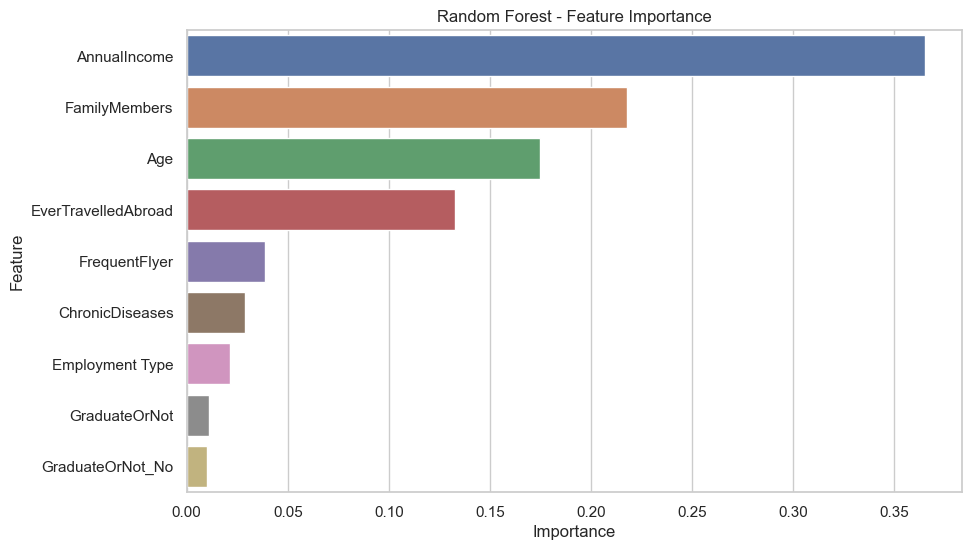

In [63]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf, x="Importance", y="Feature")
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Interpretation of the feature importances from Random Forest model:
- Annual Income: Higher income correlates with a higher likelihood of purchasing travel insurance.
- Family Members: More family members suggest a greater inclination to buy insurance.
- Age: Younger individuals are more likely to purchase travel insurance.
- Ever Travelled Abroad: Past international travel increases the likelihood of buying insurance.
- Frequent Flyer: Frequent flyers are more inclined to purchase travel insurance.
- Chronic Diseases: Having chronic diseases indicates a slightly higher chance of buying insurance.
- Employment Type: Employment status has a modest influence on insurance purchase.
- Graduate or Not: Graduation status has a minor impact on insurance purchase.

#### 5.1.3 Visualization of the Models

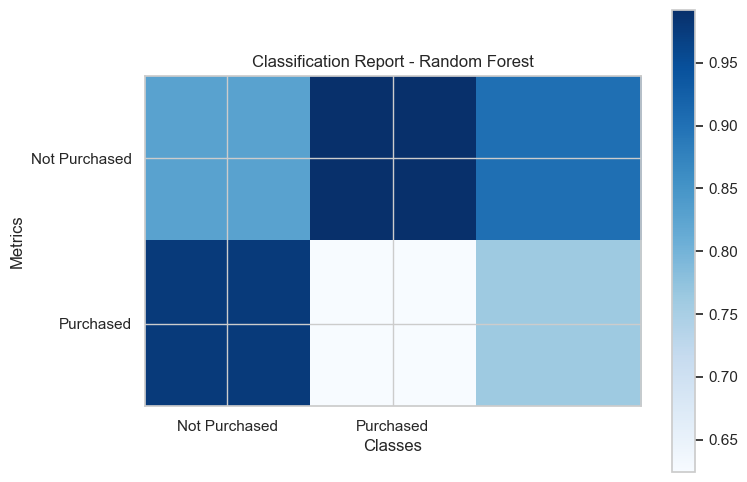

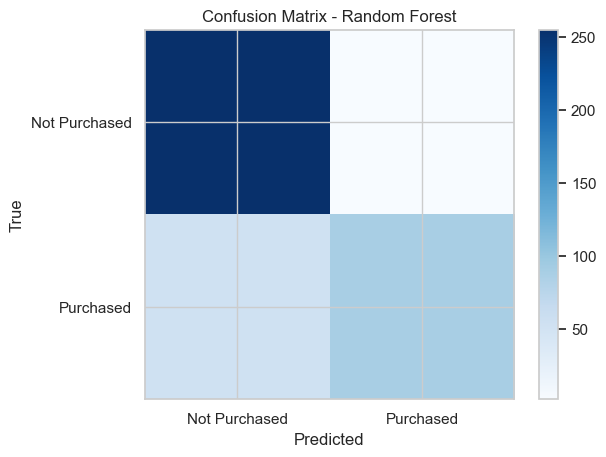

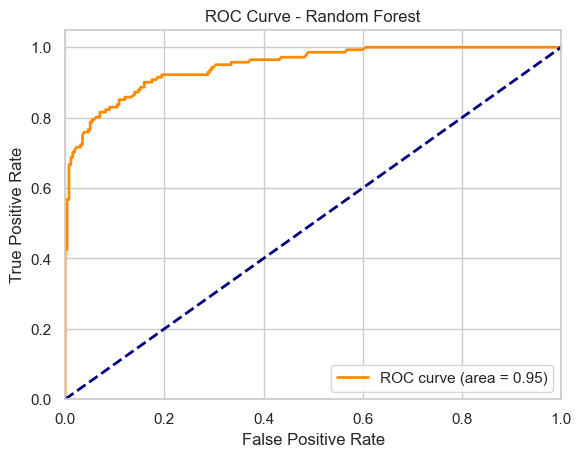

In [64]:
model = best_rf_model
name = "Random Forest"

y_pred = model.predict(X_test_transformed)
y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

plot_classification_report(
    y_test,
    y_pred,
    class_names=["Not Purchased", "Purchased"],
    title=f"Classification Report - {name}",
)
plot_confusion_matrix(
    y_test,
    y_pred,
    class_names=["Not Purchased", "Purchased"],
    title=f"Confusion Matrix - {name}",
)
plot_roc_curve(y_test, y_pred_prob, title=f"ROC Curve - {name}")

Interpretation of the results for the Random Forest model:
- Accuracy: The model accurately predicts classes for 86% of the samples.
- "Not Purchased" Class:
  - Precision: 83% of predicted "Not Purchased" instances are correct.
  - Recall: 99% of actual "Not Purchased" instances are identified.
- "Purchased" Class:
  - Precision, Recall, and F1-score are lower than for "Not Purchased" class.
- Confusion Matrix: 255 correct "Not Purchased," 88 correct "Purchased," and 53 incorrect "Purchased" predictions.
- ROC Curve: AUC value of approximately 0.96, indicating good discrimination between classes.

These metrics collectively provide insights into the model's performance in distinguishing between the classes and its overall predictive capabilities.

### 5.2 Logistic Regression

In [65]:
# initialize and train the logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_transformed, y_train)

LogisticRegression(random_state=42)

In [66]:
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(
    lr_model, X_test_transformed, y_test
)
print("Logistic Regression Model Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-score:", f1_lr)

Logistic Regression Model Metrics:
Accuracy: 0.7688442211055276
Precision: 0.7692307692307693
Recall: 0.49645390070921985
F1-score: 0.603448275862069


In [67]:
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train_transformed, y_train)

best_lr_model = grid_search_lr.best_estimator_

In [68]:
accuracy_best_lr, precision_best_lr, recall_best_lr, f1_best_lr = evaluate_model(
    best_lr_model, X_test_transformed, y_test
)
print("Best Logistic Regression Model Metrics:")
print("Accuracy:", accuracy_best_lr)
print("Precision:", precision_best_lr)
print("Recall:", recall_best_lr)
print("F1-score:", f1_best_lr)

Best Logistic Regression Model Metrics:
Accuracy: 0.7763819095477387
Precision: 0.8023255813953488
Recall: 0.48936170212765956
F1-score: 0.6079295154185022


Overall, based on the metrics, the best-tuned RandomForestClassifier seems to perform better than the Logistic Regression model. It has higher accuracy, significantly higher precision, slightly higher recall, and a higher F1-score.

### 5.3 Gradient Boosting Model

In [69]:
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_transformed, y_train)

GradientBoostingClassifier(random_state=42)

In [70]:
# Evaluate the model on the testing data
accuracy_gb, precision_gb, recall_gb, f1_gb = evaluate_model(
    gb_model, X_test_transformed, y_test
)
print("Gradient Boosting Model Metrics:")
print("Accuracy:", accuracy_gb)
print("Precision:", precision_gb)
print("Recall:", recall_gb)
print("F1-score:", f1_gb)

Gradient Boosting Model Metrics:
Accuracy: 0.8442211055276382
Precision: 0.9876543209876543
Recall: 0.5673758865248227
F1-score: 0.7207207207207208


In [71]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [72]:
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train_transformed, y_train)
best_gb_model = grid_search.best_estimator_

In [73]:
# Evaluate the best-tuned model on the testing data
accuracy_best_gb, precision_best_gb, recall_best_gb, f1_best_gb = evaluate_model(
    best_gb_model, X_test_transformed, y_test
)

print("Best Gradient Boosting Model Metrics:")
print("Accuracy:", accuracy_best_gb)
print("Precision:", precision_best_gb)
print("Recall:", recall_best_gb)
print("F1-score:", f1_best_gb)

Best Gradient Boosting Model Metrics:
Accuracy: 0.8442211055276382
Precision: 0.9876543209876543
Recall: 0.5673758865248227
F1-score: 0.7207207207207208


Insights:
- Best Gradient Boosting Model, and normal Gradient Boosting Model have the same performance.
- If we only  prioritize precision, then the Gradient Boosting model could be a strong candidate.

### 5.4 Support Vector Machine Model

In [74]:
# initialize and train SVC model
svm_model = SVC(random_state=42)
svm_model.fit(X_train_transformed, y_train)

SVC(random_state=42)

In [75]:
# Evaluate the SVM model on the testing data
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(
    svm_model, X_test_transformed, y_test
)

print("SVM Model Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_svm)

SVM Model Metrics:
Accuracy: 0.8090452261306532
Precision: 0.8735632183908046
Recall: 0.5390070921985816
F1-score: 0.6666666666666666


In [76]:
# Define the parameter grid for SVM
param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
}

svm_model = SVC(random_state=42)
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5)

grid_search_svm.fit(X_train_transformed, y_train)
best_svm_model = grid_search_svm.best_estimator_

In [77]:
# Evaluate the best SVM model on the testing data
accuracy_best_svm, precision_best_svm, recall_best_svm, f1_best_svm = evaluate_model(
    best_svm_model, X_test_transformed, y_test
)

print("Best SVM Model Metrics:")
print("Accuracy:", accuracy_best_svm)
print("Precision:", precision_best_svm)
print("Recall:", recall_best_svm)
print("F1-score:", f1_best_svm)

Best SVM Model Metrics:
Accuracy: 0.8115577889447236
Precision: 0.8928571428571429
Recall: 0.5319148936170213
F1-score: 0.6666666666666667


Overall, each model has its strengths and weaknesses. The Random Forest and Gradient Boosting models seem to have higher accuracy and precision, while the Support Vector Machine and Logistic Regression models have a good balance of precision and recall.

## 6. Summary

In summary, our project journey led to the following key results:

1. **Insightful Exploration:** Thorough data exploration revealed patterns and relationships in features like age, income, family size, and health history.
2. **Informed Inference:** Statistical testing provided insights into significant associations, such as the impact of annual income on travel insurance adoption.
3. **Effective Modeling:** Leveraging Random Forest and Gradient Boosting, we constructed predictive models that demonstrated strong performance.
4. **Performance Metrics:** Model evaluation yielded promising metrics, including accuracy, precision, recall, and F1-score, showcasing the models' predictive capabilities.

## 7. Future Suggestion

1. **Feature Engineering**: Experiment with advanced feature engineering to capture more insights and relationships.
2. **Fine-Tuned Hyperparameters**: Explore advanced tuning methods like Bayesian optimization for optimal performance.
3. **Time Insights**: Analyze time-related data for seasonal patterns in travel insurance decisions.
4. **Hosting the Model**: 